<a href="https://colab.research.google.com/github/Sengathir24/SOTA-Segmentation-using-Basnet/blob/main/BASNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Clone source code from GitHub

In [ ]:
!git clone https://github.com/NathanUA/BASNet.git

Cloning into 'BASNet'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 255 (delta 66), reused 57 (delta 57), pack-reused 182 (from 1)
Receiving objects: 100% (255/255), 3.60 MiB | 20.68 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [ ]:
%cd BASNet

/content/BASNet


# 2.Download pre trained weight

In [ ]:
!pip install gdown

In [ ]:
import os
import gdown
os.makedirs('./saved_models/basnet_bsi', exist_ok=True)
gdown.download('https://drive.google.com/uc?id=1s52ek_4YTDRt_EOkx1FS53u-vJa0c4nu',
    './saved_models/basnet_bsi/basnet.pth',
    quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1s52ek_4YTDRt_EOkx1FS53u-vJa0c4nu
From (redirected): https://drive.google.com/uc?id=1s52ek_4YTDRt_EOkx1FS53u-vJa0c4nu&confirm=t&uuid=b62126ec-3bdf-490c-a8d6-8bd9868ceb5c
To: /content/BASNet/saved_models/basnet_bsi/basnet.pth
100%|██████████| 348M/348M [00:05<00:00, 58.5MB/s]


'./saved_models/basnet_bsi/basnet.pth'

# 3.Run basnet_test.py

In [ ]:
!python basnet_test.py

...load BASNet...
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100% 83.3M/83.3M [00:00<00:00, 205MB/s]
/content/BASNet/basnet_test.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is

# 4.Display a result

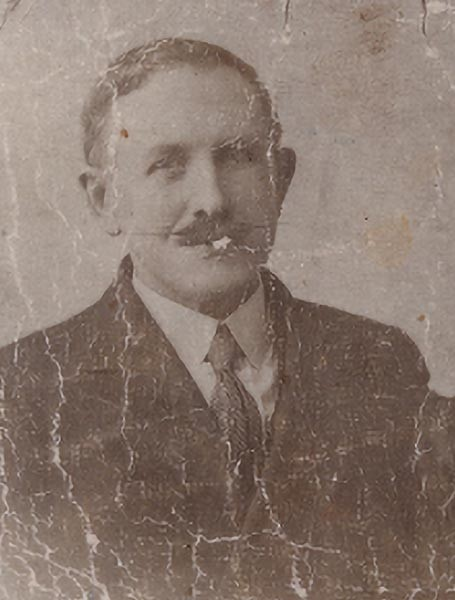

In [ ]:
from PIL import Image
from IPython.display import display
img_input = Image.open('/content/BASNet/test_data/test_images/upscale-low-resolution-photo-before.jpg')
display(img_input)

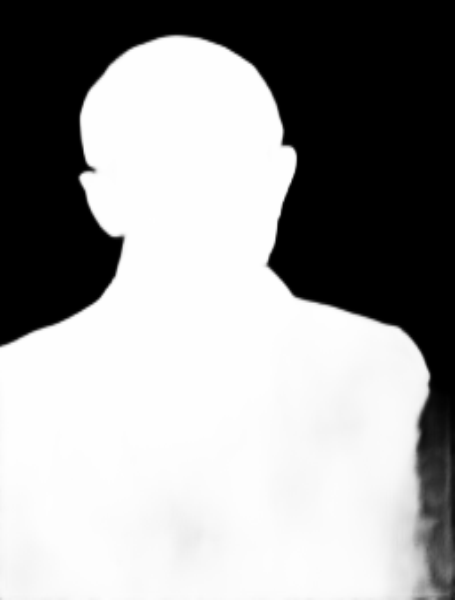

In [ ]:
img_output = Image.open('/content/BASNet/test_data/test_results/upscale-low-resolution-photo-before.png')
display(img_output)

# To Train the model

In [ ]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import torchvision.transforms as standard_transforms

import numpy as np
import glob
import os  # Added for file operations

from data_loader import SalObjDataset  # Import your dataset and necessary transformations
from model import BASNet  # Import your model
from data_loader import RescaleT
from data_loader import ToTensorLab
from data_loader import RandomCrop

import pytorch_ssim
import pytorch_iou

# ------- 1. define loss function --------

bce_loss = nn.BCELoss(size_average=True)
ssim_loss = pytorch_ssim.SSIM(window_size=11, size_average=True)
iou_loss = pytorch_iou.IOU(size_average=True)

def bce_ssim_loss(pred, target):
    bce_out = bce_loss(pred, target)
    ssim_out = 1 - ssim_loss(pred, target)
    iou_out = iou_loss(pred, target)
    loss = bce_out + ssim_out + iou_out
    return loss

def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, d7, labels_v):
    loss0 = bce_ssim_loss(d0, labels_v)
    loss1 = bce_ssim_loss(d1, labels_v)
    loss2 = bce_ssim_loss(d2, labels_v)
    loss3 = bce_ssim_loss(d3, labels_v)
    loss4 = bce_ssim_loss(d4, labels_v)
    loss5 = bce_ssim_loss(d5, labels_v)
    loss6 = bce_ssim_loss(d6, labels_v)
    loss7 = bce_ssim_loss(d7, labels_v)
    loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7
    print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n" % (loss0.item(), loss1.item(), loss2.item(), loss3.item(), loss4.item(), loss5.item(), loss6.item()))
    return loss0, loss

# ------- 2. set the directory of training dataset --------
data_dir = '/content/sample_data'
tra_image_dir = '/content/sample_data/DUTS-TR-Image/'
tra_label_dir = '/content/sample_data/DUTS_TR_Ma/'

image_ext = '.jpg'
label_ext = '.png'

model_dir = '/content/BASNet/saved_models/basnet_bsi'

epoch_num = 50
batch_size_train = 16
batch_size_val = 2
train_num = 0
val_num = 0

tra_img_name_list = glob.glob(tra_image_dir + '*' + image_ext)  # Updated path

tra_lbl_name_list = []
for img_path in tra_img_name_list:
    img_name = os.path.basename(img_path)
    lbl_name = os.path.join(tra_label_dir, os.path.splitext(img_name)[0] + label_ext)
    tra_lbl_name_list.append(lbl_name)

print("---")
print("train images: ", len(tra_img_name_list))
print("train labels: ", len(tra_lbl_name_list))
print("---")

train_num = len(tra_img_name_list)

salobj_dataset = SalObjDataset(
    img_name_list=tra_img_name_list,
    lbl_name_list=tra_lbl_name_list,
    transform=transforms.Compose([
        RescaleT(256),
        RandomCrop(224),
        ToTensorLab(flag=0)]))

salobj_dataloader = DataLoader(salobj_dataset, batch_size=batch_size_train, shuffle=True, num_workers=1)

# ------- 3. define model --------
# Define the net
net = BASNet(3, 1)
if torch.cuda.is_available():
    net.cuda()

# ------- 4. define optimizer --------
print("---define optimizer...")
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# ------- 5. training process --------
print("---start training...")
ite_num = 0
running_loss = 0.0
running_tar_loss = 0.0
ite_num4val = 0

for epoch in range(epoch_num):
    net.train()

    for i, data in enumerate(salobj_dataloader):
        ite_num += 1
        ite_num4val += 1

        inputs, labels = data['image'], data['label']

        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        # Wrap them in Variable
        if torch.cuda.is_available():
            inputs_v, labels_v = Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(), requires_grad=False)
        else:
            inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        d0, d1, d2, d3, d4, d5, d6, d7 = net(inputs_v)
        loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, d7, labels_v)

        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        running_tar_loss += loss2.item()

        # Delete temporary outputs and loss
        del d0, d1, d2, d3, d4, d5, d6, d7, loss2, loss

        print("[epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f accuracy: %2f " % (
            epoch + 1, epoch_num, (i + 1) * batch_size_train, train_num, ite_num, running_loss / ite_num4val,
            running_tar_loss / ite_num4val,100 - (running_loss / ite_num4val) ))

        if ite_num % 2000 == 0:  # Save model every 2000 iterations
            torch.save(net.state_dict(),
                       model_dir + "basnet_bsi_itr_%d_train_%3f_tar_%3f.pth" % (
                           ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))
            running_loss = 0.0
            running_tar_loss = 0.0
            net.train()  # Resume train
            ite_num4val = 0

print('-------------Congratulations! Training Done!!!-------------')

[epoch:  28/ 50, batch:   288/  480, ite: 828] train loss: 5.934061, tar: 0.632016 accuracy: 94.065939 
l0: 0.320652, l1: 0.320882, l2: 0.329485, l3: 0.343288, l4: 0.400374, l5: 0.505457, l6: 0.732804

[epoch:  28/ 50, batch:   304/  480, ite: 829] train loss: 5.931352, tar: 0.631641 accuracy: 94.068648 
l0: 0.327483, l1: 0.330795, l2: 0.337249, l3: 0.354625, l4: 0.397033, l5: 0.479147, l6: 0.671033

[epoch:  28/ 50, batch:   320/  480, ite: 830] train loss: 5.928493, tar: 0.631274 accuracy: 94.071507 
l0: 0.301215, l1: 0.303924, l2: 0.307906, l3: 0.338526, l4: 0.403506, l5: 0.526678, l6: 0.785667

[epoch:  28/ 50, batch:   336/  480, ite: 831] train loss: 5.925811, tar: 0.630877 accuracy: 94.074189 
l0: 0.252974, l1: 0.256187, l2: 0.256275, l3: 0.279982, l4: 0.305208, l5: 0.385991, l6: 0.599848

[epoch:  28/ 50, batch:   352/  480, ite: 832] train loss: 5.922203, tar: 0.630423 accuracy: 94.077797 
l0: 0.293351, l1: 0.295098, l2: 0.304190, l3: 0.318917, l4: 0.374120, l5: 0.473383, l6: 

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import cv2
import numpy as np

# Define image normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Define loss functions
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

class JaccardLoss(nn.Module):
    def __init__(self):
        super(JaccardLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        jaccard = (intersection + smooth) / (union + smooth)
        return 1 - jaccard

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        BCE_loss = nn.BCELoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss


In [ ]:

# Add attention modules
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        attention = self.conv(x)
        attention = self.softmax(attention)
        return x * attention

# Atrous Convolutions and ASPP
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, dilation=1)
        self.atrous_block2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2)
        self.atrous_block3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3, dilation=3)
        self.conv2 = nn.Conv2d(out_channels*4, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.atrous_block1(x)
        x3 = self.atrous_block2(x)
        x4 = self.atrous_block3(x)
        x = torch.cat([x1, x2, x3, x4], dim=1)
        x = self.conv2(x)
        return x


In [ ]:

# Histogram Equalization
def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output

# Contour Extraction
def contour_extraction(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges = np.expand_dims(edges, axis=-1)
    return np.concatenate((img, edges), axis=-1)

# Example usage in dataset preparation
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx], 0)

        # Apply histogram equalization
        image = histogram_equalization(image)

        # Generate contour map and concatenate with original image
        image = contour_extraction(image)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [ ]:

# Define model, optimizer, and learning rate scheduler
model = MySegmentationModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = DiceLoss()(outputs, masks)  # Change this to JaccardLoss or FocalLoss as needed

        loss.backward()
        optimizer.step()

    # Step the scheduler
    scheduler.step(loss)


In [ ]:
import os
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2
import numpy as np
from PIL import Image
import glob

from data_loader import RescaleT
from data_loader import CenterCrop
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset
from model import BASNet

# Define image normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Define loss functions
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

class JaccardLoss(nn.Module):
    def __init__(self):
        super(JaccardLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        jaccard = (intersection + smooth) / (union + smooth)
        return 1 - jaccard

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        BCE_loss = nn.BCELoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss

# Add attention modules
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        attention = self.conv(x)
        attention = self.softmax(attention)
        return x * attention

# Atrous Convolutions and ASPP
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, dilation=1)
        self.atrous_block2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2)
        self.atrous_block3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3, dilation=3)
        self.conv2 = nn.Conv2d(out_channels*4, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.atrous_block1(x)
        x3 = self.atrous_block2(x)
        x4 = self.atrous_block3(x)
        x = torch.cat([x1, x2, x3, x4], dim=1)
        x = self.conv2(x)
        return x

# Histogram Equalization
def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output

# Contour Extraction
def contour_extraction(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges = np.expand_dims(edges, axis=-1)
    return np.concatenate((img, edges), axis=-1)

# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx], 0)

        # Apply histogram equalization
        image = histogram_equalization(image)

        # Generate contour map and concatenate with original image
        image = contour_extraction(image)

        sample = {'image': image, 'label': mask}

        if self.transform:
            sample = self.transform(sample)

        return sample['image'], sample['label']

# Define paths and prepare datasets
image_dir = './test_data/test_images/'
mask_dir = './test_data/test_masks/'
img_name_list = glob.glob(image_dir + '*.jpg')
mask_name_list = [mask_dir + os.path.basename(img_path) for img_path in img_name_list]

# Initialize the custom dataset and dataloader
custom_dataset = CustomDataset(img_name_list, mask_name_list, transform=transforms.Compose([RescaleT(256), ToTensorLab(flag=0)]))
dataloader = DataLoader(custom_dataset, batch_size=1, shuffle=True, num_workers=1)

# Load the BASNet model
model_dir = './saved_models/basnet_bsi/basnet.pth'
model = BASNet(3, 1)  # Replace BASNet with the actual class name if different
model.load_state_dict(torch.load(model_dir))
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
num_epochs = 20  # Fixed number of epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = DiceLoss()(outputs, masks)  # Change this to JaccardLoss or FocalLoss as needed

        loss.backward()
        optimizer.step()

    # Step the scheduler
    scheduler.step(loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Save the model
model_save_path = "./saved_models/basnet_bsi/basnet.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")
